# Miniproject 1: Image Classification

## Introduction

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://deeplearning.net/tutorial/logreg.html). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that was [recently extended](https://arxiv.org/abs/1702.05373). We break with this tradition (just a little bit) and tackle first the related problem of classifying cropped, downsampled and grayscaled images of house numbers in the [The Street View House Numbers (SVHN) Dataset](http://ufldl.stanford.edu/housenumbers/).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook.

### Your names

Before you start, please enter your full name(s) in the field below; they are used to load the data. The variable student2 may remain empty, if you work alone.

- **Olesia Altunina** (285467)
- **Léonore Guillain** (233984)

In [23]:
student1 = 285467
student2 = 233984

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [24]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

# Olesya's imports
import json
import time
import timeit
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.pyplot import cm
fig_size = 12, 8
plt.rcParams["figure.figsize"] = fig_size
plt.style.use('ggplot')
%matplotlib inline

# Leonore's imports
from keras import backend as K
from keras.layers import BatchNormalization, regularizers

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import SGD, Adam


# you may experiment with different subsets, 
# but make sure in the submission 
# it is generated with the correct random seed for all exercises.
np.random.seed(hash(student1 + student2) % 2**32)
subset_of_classes = np.random.choice(range(10), 5, replace = False)

### Plotting

In [59]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 16, ydim = 16,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
#    return fig # Mute for %matplotinline

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('Categorical cross-entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('Accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
#    return fig # Mute for %matplotinline

### Additional Helpers

In [60]:
def get_legend(colormap, vars_, lines=True):
    """Creates a legend with patches and lines for plotting learning curves."""
    
    color_iter = iter(colormap)
    color=next(color_iter)
    legend = []
    if lines:
        legend.append(mlines.Line2D([], [], color=color, linestyle='--', label='Training'))
        legend.append(mlines.Line2D([], [], color=color, alpha=0.3, label='Validation'))

    color_iter = iter(colormap)
    for var in vars_:
        legend.append(mpatches.Patch(color=next(color_iter), label=var))

    return legend

def plot(histories, labels, title, mode, complementary=True):
    """Plots a set of learning curves in one mode (loss OR accuracy) for give histories.
    
    Params:
    -------
    histories - list of histories (keras.History.history or Extended/Appended History),
    labels - list of labels (for the legend),
    title - string, title of the plot,
    mode - str, {'acc', 'val_acc', 'loss', 'val_loss'},
    complementary - bulean, whether to plot complementary curve (validation is "complementary" to training).
    """
    
    get_ylabel = lambda mode: 'Accuracy' if mode in ['acc', 'val_acc'] else 'Loss'
    plt.title(title)
    plt.ylabel(get_ylabel(mode))
    plt.xlabel('Epochs')

    colormap = cm.brg(np.linspace(0, 1, len(labels)))
    if complementary:
        plt.legend(handles=get_legend(colormap, labels), loc='upper right')
    else:
        plt.legend(handles=get_legend(colormap, labels, lines=False), loc='upper right')

    linestyles = ['--', '-']
    alphas = [1, 0.3]
    if mode.startswith('val_'): ind = 1
    else: ind = 0
    color_iter = iter(colormap)
    for val in histories:
        color = next(color_iter)
        plt.plot(val[mode], linestyle=linestyles[ind], color=color, alpha=alphas[ind])
    if complementary:
        if ind == 1:
            mode_2 = mode[4:]
        else:
            mode_2 = 'val_{}'.format(mode)
        color_iter = iter(colormap)
        for val in histories:
            color = next(color_iter)
            plt.plot(val[mode_2], '-', color=color, alpha=0.3)

def plot_acc_loss(histories, labels, title, prefix_1, prefix_2=None):
    """Plots both accuracy and validation curves for given histories.
    
    Params:
    -------
    histories - list of histories (keras.History.history or Extended/Appended History),
    labels - list of labels (for the legend),
    title - string, title of the plot,
    prefix_1 - {'', 'val_'}, the first prefix,
    prefix_2 - {'', 'val_'}, the second prefix, optional.
    
    Prefixes allow plotting ONLY training or validation or BOTH.
    """
    
    fig = plt.figure(figsize=(12,8))
    ax = []
    ax.append(fig.add_subplot(211))
    ax.append(fig.add_subplot(212))

    ax[0].set_title(title)
    ax[0].set_ylabel('Accuracy')
    ax[1].set_ylabel('Loss')
    ax[0].set_xlabel('Epochs')
    ax[1].set_xlabel('Epochs')

    colormap = cm.brg(np.linspace(0, 1, len(labels)))
    
    for i, mode in enumerate(['acc', 'loss']):
        color_iter = iter(colormap)
        linestyles = ['--', '-']
        alphas = [1, 0.3]
        if prefix_1 == 'val_':
            ind = 1
        else:
            ind = 0
        for val in histories:
            color = next(color_iter)
            ax[i].plot(val[prefix_1 + mode], linestyle=linestyles[ind], color=color, alpha=alphas[ind])
        del linestyles[ind]
        del alphas[ind]
        if prefix_2:
            color_iter = iter(colormap)
            for val in histories:
                color = next(color_iter)
                ax[i].plot(val[prefix_2 + mode], linestyles[0], color=color, alpha=alphas[0])

    # Put the legend to the right of the current axis
    for i in [0, 1]:
        box = ax[i].get_position()
        ax[i].set_position([box.x0, box.y0, box.width * 0.8, box.height])
        
    if prefix_2:
        legend = get_legend(colormap, labels)
    else:
        legend = get_legend(colormap, labels, lines=False)
    ax[0].legend(handles=legend, loc='lower right')#, bbox_to_anchor=(1.145, 1.0))
    
def get_box_dict(tag, iters):
    """Ex 5: Extracts the stats for the boxplots."""
    
    fpath = 'output_Olesya/{}/'.format(tag)
    return {
        'acc': [AppendedHistory(fname='{}apphist_{}_{}_{}.txt'.format(fpath, tag, iters, i)).get_best()['acc'] \
                 for i in range(2, 5)],
        'val_acc': [AppendedHistory(fname='{}apphist_{}_{}_{}.txt'.format(fpath, tag, iters, i)).get_best()['val_acc'] \
                 for i in range(2, 5)],
        'loss': [AppendedHistory(fname='{}apphist_{}_{}_{}.txt'.format(fpath, tag, iters, i)).get_best()['loss'] \
                 for i in range(2, 5)],
        'val_loss': [AppendedHistory(fname='{}apphist_{}_{}_{}.txt'.format(fpath, tag, iters, i)).get_best()['val_loss'] \
                 for i in range(2, 5)]
    }
    
def plot_stats(box_dict, title, xlabel, ylim_loss, ylim_acc, savename, labels, log=False):
    """Plots stats boxplots.
    
    Params:
    -------
    box_dict - dict, metrics dictribution.
    """
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

    bplots = []
    for key in box_dict.keys():
        if key.endswith('loss'):
            bplots.append(ax[0].boxplot(box_dict[key], patch_artist=True, labels=labels))
        else:
            bplots.append(ax[1].boxplot(box_dict[key], patch_artist=True, labels=labels))

    fig.suptitle(title, fontsize=16)

    ax[0].set_xlabel(xlabel)
    ax[1].set_xlabel(xlabel)
    ax[0].set_ylabel('Loss')
    ax[1].set_ylabel('Accuracy')
    ax[0].set_ylim(ylim_loss)
    ax[1].set_ylim(ylim_acc)
    if log:
        ax[0].set_yscale('log')
        ax[1].set_yscale('log')

    colormap = cm.Wistia(np.linspace(0, 1, len(box_dict)))

    ax[0].legend(handles=get_legend(colormap[2:], ['Training', 'Validation'], lines=False), loc='upper left')
    ax[1].legend(handles=get_legend(colormap[:2], ['Training', 'Validation'], lines=False), loc='upper left')

    for ind, bplot in enumerate(bplots):
        for patch in bplot['boxes']:
            patch.set_facecolor(colormap[ind])

    fig.savefig('output_Olesya/pics/{}.png'.format(savename), dpi=300)

**NB:** Helper ↓ from: https://github.com/keras-team/keras/issues/341

In [61]:
def shuffle_weights(model, weights=None):
    """Randomly permute the weights in `model`, or the given `weights`.

    This is a fast approximation of re-initializing the weights of a model.

    Assumes weights are distributed independently of the dimensions of the weight tensors
      (i.e., the weights have the same distribution along each dimension).

    :param Model model: Modify the weights of the given model.
    :param list(ndarray) weights: The model's weights will be replaced by a random permutation of these weights.
      If `None`, permute the model's current weights.
    """
    if weights is None:
        weights = model.get_weights()
    weights = [np.random.permutation(w.flat).reshape(w.shape) for w in weights]
    # Faster, but less random: only permutes along the first dimension
    # weights = [np.random.permutation(w) for w in weights]
    model.set_weights(weights)

In [62]:
class ExtendedHistory:
    """A class for saving training history for further training of the same model."""
    
    def __init__(self, history_=None, fname=None):
        if history_:
            self.history = history_
        elif fname:
            with open(fname, 'r') as file:
                self.history = json.load(file)
        else:
            self.history = {
                'loss': [],
                'val_loss': [],
                'acc': [],
                'val_acc': []
            }
        
    def add_hist(self, history):
        self.history['acc'] = list(np.concatenate((self.history['acc'], history.history['acc'])))
        self.history['val_acc'] = list(np.concatenate((self.history['val_acc'], history.history['val_acc'])))
        self.history['loss'] = list(np.concatenate((self.history['loss'], history.history['loss'])))
        self.history['val_loss'] = list(np.concatenate((self.history['val_loss'], history.history['val_loss'])))
        
    def save(self, fname):
        with open(fname, 'w') as file:
            file.write(json.dumps(self.history))
        
    def plot(self, title):
        fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
        ax1.plot(self.history['loss'], label = "training")
        ax1.plot(self.history['val_loss'], label = "validation")
        ax2.plot(self.history['acc'], label = "training")
        ax2.plot(self.history['val_acc'], label = "validation")
        finalize_standardplot(fig, ax1, ax2)
#        return fig # Mute for %matplotinline

In [63]:
class AppendedHistory:
    """A class for saving and plotting histories for multiple iterations
    of a set of models with a varied hyperparameter (variable)."""
    
    def __init__(self, varname=None, history_=None, fname=None):
        if history_:
            self.history = history_
        elif fname:
            with open(fname, 'r') as file:
                self.history = json.load(file)
        else:
            self.history = {
                'loss': [],
                'val_loss': [],
                'acc': [],
                'val_acc': [],
                'var': []
            }
        self.varname = varname
        
    def append_hist(self, var, history):
        """Append fitting history for a new variable."""
        for key in self.history.keys():
            if key != 'var':
                self.history[key].append(history.history[key])
            else:
                self.history['var'].append(var)
        
    def add_hist(self, var, history):
        """Add further fitting history to a certain variable."""
        ind = self.history['var'].index(var)
        for key in self.history.keys():
            if key != 'var':
                self.history[key][ind] = self.history[key][ind] + history.history[key]
                
    def merge(self, history):
        """Merge 2 histories."""
        for key in self.history.keys():
            self.history[key] = self.history[key] + history.history[key]
        
    def save(self, fname):
        with open(fname, 'w') as file:
            file.write(json.dumps(self.history))
            
    def get_single_var(self, var):
        """Get the history for a single variable as a new object."""
        new_hist = AppendedHistory()
        ind = self.history['var'].index(var)
        for key in self.history.keys():
            new_hist.history[key] = self.history[key][ind]
        return new_hist
    
    def get_slice(self, slice_):
        """Get the histories for a given slice of variables as a new object."""
        new_hist = AppendedHistory()
        for key in self.history.keys():
            if type(slice_) == int:
                new_hist.history[key] = [self.history[key][slice_]]
            else:
                new_hist.history[key] = self.history[key][slice_]
        return new_hist
    
    def get_sample_slice(self, slice_):
        """Get the sample of a given slice throughout all the variables as a new object."""
        new_hist = AppendedHistory()
        for key in self.history.keys():
            if key != 'var':
                for v in self.history[key]:
                    new_hist.history[key].append(v[slice_])
        return new_hist
        
    def plot(self, title, mode, complementary=True):
        """Plots a set of learning curves in one mode (loss OR accuracy) for give histories.
    
        Params:
        -------
        title - string, title of the plot,
        mode - str, {'acc', 'val_acc', 'loss', 'val_loss'},
        complementary - bulean, whether to plot complementary curve (validation is "complementary" to training).
        """
        get_ylabel = lambda mode: 'Accuracy' if mode in ['acc', 'val_acc'] else 'Loss'
        plt.title(title)
        plt.ylabel(get_ylabel(mode))
        plt.xlabel('Epochs')
        
        colormap = cm.gist_rainbow(np.linspace(0, 1, len(self.history['var'])))
        print(colormap)
        if complementary:
            plt.legend(handles=get_legend(colormap, self.history['var']), loc='upper right')
        else:
            plt.legend(handles=get_legend(colormap, self.history['var'], lines=False), loc='upper right')

        linestyles = ['--', '-']
        alphas = [1, 0.3]
        if mode.startswith('val_'): ind = 1
        else: ind = 0
        color_iter = iter(colormap)
        for val in self.history[mode]:
            print(val)
            color = next(color_iter)
            plt.plot(val, linestyle=linestyles[ind], color=color, alpha=alphas[ind])
        if complementary:
            if ind == 1:
                mode_2 = mode[4:]
            else:
                mode_2 = 'val_{}'.format(mode)
            color_iter = iter(colormap)
            for val in self.history[mode_2]:
                color = next(color_iter)
                plt.plot(val, '-', color=color, alpha=0.3)
            
    def plot_acc_loss(self, title, prefix_1, prefix_2=None, slice_=slice(None)):
        """Plots both accuracy and validation traces for given histories.
    
        Params:
        -------
        title - string, title of the plot,
        prefix_1 - {'', 'val_'}, the first prefix,
        prefix_2 - {'', 'val_'}, the second prefix, optional.
        
        Prefixes allow plotting ONLY training or validation or BOTH."""
        
        fig = plt.figure(figsize=(12,8))
        ax = []
        ax.append(fig.add_subplot(211))
        ax.append(fig.add_subplot(212))

        ax[0].set_title(title)
        ax[0].set_ylabel('Accuracy')
        ax[1].set_ylabel('Loss')
        ax[0].set_xlabel('Epochs')
        ax[1].set_xlabel('Epochs')
        ax[1].set_yscale('log')

        colormap = cm.gist_rainbow(np.linspace(0, 1, len(self.history['var'])))[slice_]
        
        for i, mode in enumerate(['acc', 'loss']):
            color_iter = iter(colormap)
            linestyles = ['--', '-']
            alphas = [1, 0.3]
            if prefix_1 == 'val_': ind = 1
            else: ind = 0
            for val in self.history[prefix_1 + mode][slice_]:
                color = next(color_iter)
                ax[i].plot(val, linestyle=linestyles[ind], color=color, alpha=alphas[ind])
            del linestyles[ind]
            del alphas[ind]
            if prefix_2:
                color_iter = iter(colormap)
                for val in self.history[prefix_2 + mode][slice_]:
                    color = next(color_iter)
                    ax[i].plot(val, linestyles[0], color=color, alpha=alphas[0])
           
        for i in [0, 1]:
            box = ax[i].get_position()
            ax[i].set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # Put a legend to the right of the current axis
        if prefix_2:
            legend = get_legend(colormap, self.history['var'][slice_])
        else:
            legend = get_legend(colormap, self.history['var'][slice_], lines=False)
        ax[0].legend(handles=legend, loc='lower right')#, bbox_to_anchor=(1.135, 1.0))
        
    def get_ist(self, i):
        """For each iteration, get the i-st element of the lerning curve."""
        ist = {}
        for key in self.history.keys():
            if key != 'var':
                ist[key] = []
                for hist in self.history[key]:
                    ist[key].append(hist[i])
            else:
                continue
        return ist
    
    def get_best(self):
        """For each iteration, find the minimal val_loss index
        and return all the metrics for this index."""
        best = {}
        for key in self.history.keys():
            if key == 'val_loss':
                best[key] = []
                for hist in self.history[key]:
                    best[key].append(min(hist))
                    best_ind = hist.index(min(hist))
            else:
                continue
        for key in self.history.keys():
            if (key != 'val_loss') and (key != 'var'):
                best[key] = []
                for hist in self.history[key]:
                    best[key].append(hist[best_ind])
        return best

### Loading and preprocessing the data

The data consists of RGB color images with 32x32 pixels, loaded into an array of dimension 32x32x3x(number of images). We convert them to grayscale (using [this method](https://en.wikipedia.org/wiki/SRGB#The_reverse_transformation)) and we downsample them to images of 16x16 pixels by averaging over patches of 2x2 pixels.

With these preprocessing steps we obviously remove some information that could be helpful in classifying the images. But, since the processed data is much lower dimensional, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), where we want to try many different things without having to wait too long for computations to finish. After having gained some experience, one may want to go back to work on the 32x32 RGB images.


In [8]:
# convert RGB images x to grayscale using the formula for Y_linear in https://en.wikipedia.org/wiki/Grayscale#Colorimetric_(perceptual_luminance-preserving)_conversion_to_grayscale
def grayscale(x):
    x = x.astype('float32')/255
    x = np.piecewise(x, [x <= 0.04045, x > 0.04045], 
                        [lambda x: x/12.92, lambda x: ((x + .055)/1.055)**2.4])
    return .2126 * x[:,:,0,:] + .7152 * x[:,:,1,:]  + .07152 * x[:,:,2,:]

def downsample(x):
    return sum([x[i::2,j::2,:] for i in range(2) for j in range(2)])/4

def preprocess(data):
    gray = grayscale(data['X'])
    downsampled = downsample(gray)
    return (downsampled.reshape(16*16, gray.shape[2]).transpose(),
            data['y'].flatten() - 1)


data_train = scipy.io.loadmat('housenumbers/train_32x32.mat')
data_test = scipy.io.loadmat('housenumbers/test_32x32.mat')

x_train_all, y_train_all = preprocess(data_train)
x_test_all, y_test_all = preprocess(data_test)

### Selecting a subset of classes

We furter reduce the size of the dataset (and thus reduce computation time) by selecting only the 5 (out of 10 digits) in `subset_of_classes`.

In [9]:
def extract_classes(x, y, classes):
    indices = []
    labels = []
    count = 0
    for c in classes:
        tmp = np.where(y == c)[0]
        indices.extend(tmp)
        labels.extend(np.ones(len(tmp), dtype='uint8') * count)
        count += 1
    return x[indices], labels

x_train, y_train = extract_classes(x_train_all, y_train_all, subset_of_classes)
x_test, y_test = extract_classes(x_test_all, y_test_all, subset_of_classes)

Let us plot some examples now. The green digit at the bottom left of each image indicates the corresponding label in `y_test`.
For further usage of the function `plot_some_samples`, please have a look at its definition in the plotting section.

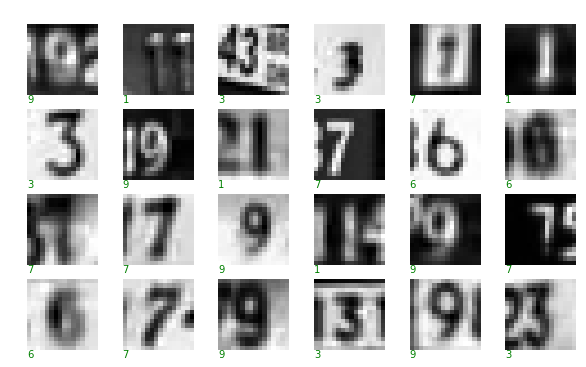

In [10]:
plot_some_samples(x_test, y_test, label_mapping = subset_of_classes)

To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing).

In [11]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

## Exercise 1: No hidden layer

### Ex 1: Description

Define and fit a model without a hidden layer. 

1. Use the `softmax` activation for the output layer.
2. Use the `categorical_crossentropy` loss.
3. Add the `accuracy` metric to the metrics.
4. Choose stochastic gradient descent (`SGD`) for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function `plot_history` defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices, label_mapping = subset_of_classes)`


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Ex 1: Solution

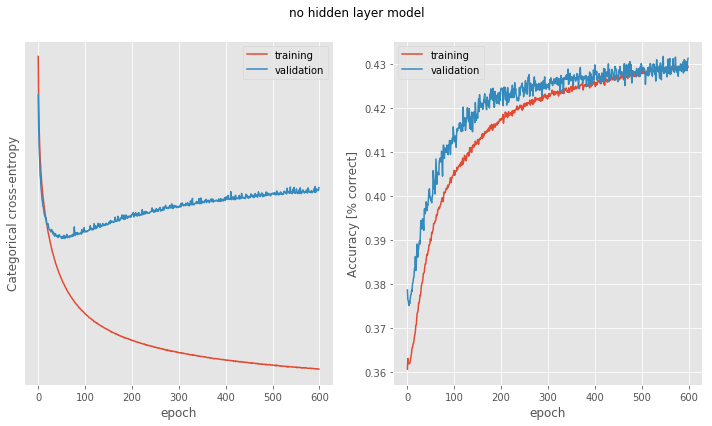

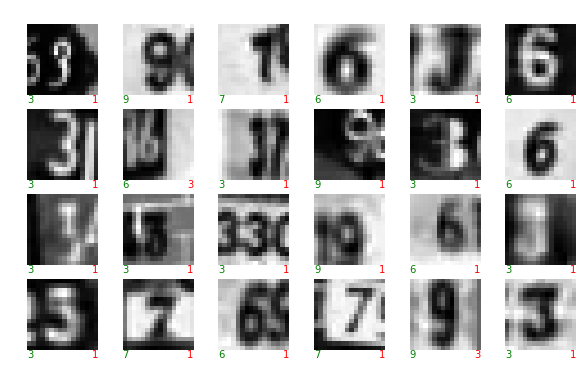

In [12]:
activation = 'softmax' #1. use softmax
loss = 'categorical_crossentropy' #2. use categorical_crossentropy for loss
metrics=['accuracy'] #3. add 'accuray' to metrics
optimizer = SGD() #4, SGD as optimizer
minibatch = 128 #5. define minibatch size

num_classes = y_test.shape[1]

model = Sequential()

model.add(Dense(num_classes, activation=activation, input_dim=x_train.shape[1]))

model.compile(loss=loss, 
              optimizer=optimizer,
              metrics=metrics)

epochs = 600 #6. fit for epochs when we don't see further decrease ca 500 epochs in.
history = model.fit(x_train, y_train, batch_size=minibatch, epochs=epochs, validation_data=(x_test, y_test), verbose=0) #validation split

#7. plot history
plot_history(history, "no hidden layer model")
plt.show()

#8. plot missclassified
pred = model.predict(x_test)
indexes = np.nonzero(pred.argmax(axis=1) != y_test.argmax(axis=1))[0]
plot_some_samples(x_test, y_test, pred, indexes, label_mapping = subset_of_classes)

## Exercise 2: One hidden layer, different optizimizers
### Ex 2: Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 64 units and the `'relu'` activation. Use the [summary method](https://keras.io/models/about-keras-models/) to inspect your model.
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent and answer the question below.
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam).
4. Plot the learning curves of SGD with a reasonable learning rate together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot.

### Ex 2: Solution

**Part 1.** Use one hidden layer with 64 units and the 'relu' activation. Use the summary method to inspect your model.

In [12]:
one_hl = Sequential()
one_hl.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
one_hl.add(Dense(5, input_dim=x_train.shape[1], activation='softmax'))
one_hl.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________


**Part 2.** Fit the model for 50 epochs with different learning rates of stochastic gradient descent and answer the question below.

In [ ]:
lrs = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 0.7, 0.9, 0.6]
inds = np.argsort(lrs)

In [ ]:
apphist_onehl = AppendedHistory() # This is a helper class. See Additional Helpers ↑. All further training and
weights = one_hl.get_weights()    # plotting in Ex 2-5 is done with this helper.

for r in sorted(lrs):
    sgd = SGD(lr=r)
    one_hl.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['acc'])
    one_hl.set_weights(weights)
    %time hist_onehl = one_hl.fit(x_train, y_train, epochs=50, batch_size=128, \
                                   verbose=0, validation_data=(x_test, y_test))
    apphist_onehl.append_hist(r, hist_one_hl)

In [ ]:
np.save('output_Olesya/apphist_onehl_sameinitws_weights', weights)
apphist_onehl.save('output_Olesya/apphist_onehl_sameinitws.txt')

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence (double click this markdown cell to edit).

**Answer**:

A) The model **does not converge** to an optimum (neither local not global), i.e. it 'sits' at a very low accuracy and a very high loss (Fig. 1).

B) The model converges **very slowly** to a local minimum that likely has a non-optimal accuracy and loss, compared to minima optained with higher learning rates. (Fig. 2).

In [13]:
apphist_onehl = AppendedHistory(varname='sgd lr', fname='output_Olesya/apphist_onehl_sameinitws.txt')

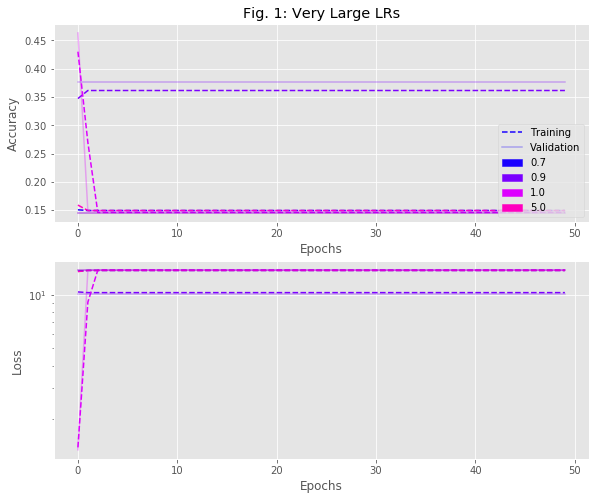

In [14]:
apphist_onehl.plot_acc_loss('Fig. 1: Very Large LRs', '', 'val_', slice(-4, None))

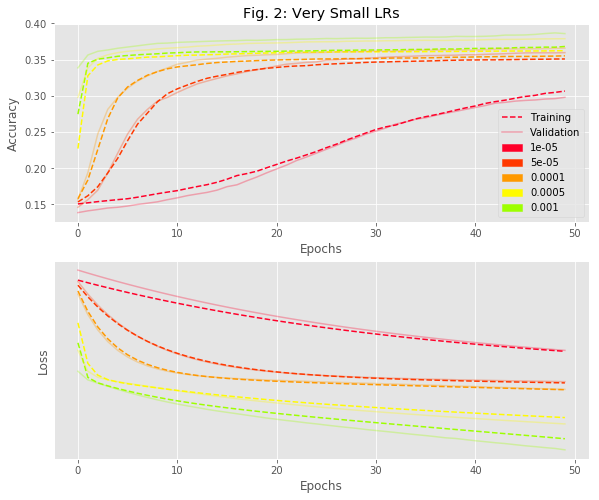

In [15]:
apphist_onehl.plot_acc_loss('Fig. 2: Very Small LRs', '', 'val_', slice(0, 5))

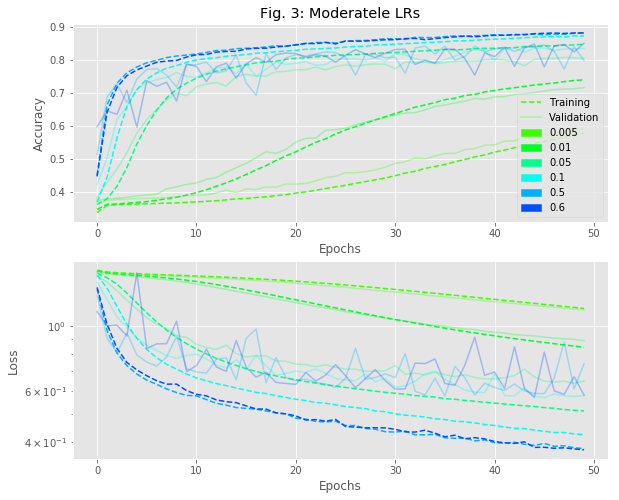

In [16]:
apphist_onehl.plot_acc_loss('Fig. 3: Moderatele LRs', '', 'val_', slice(-10, -4))

**Part 3.** Replace the stochastic gradient descent optimizer with the Adam optimizer.

In [17]:
one_hl.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
one_hl.set_weights(np.load('output_Olesya/apphist_onehl_sameinitws_weights.npy'))
%time hist_one_hl_adam = one_hl.fit(x_train, y_train, epochs=50, batch_size=128, \
                                    verbose=0, validation_data=(x_test, y_test))

CPU times: user 1min 1s, sys: 19.4 s, total: 1min 21s
Wall time: 43.6 s


In [18]:
histories = [hist_one_hl_adam.history, apphist_onehl.get_single_var(0.5).history]
labels = ['Adam', 'SGD, lr=0.5']

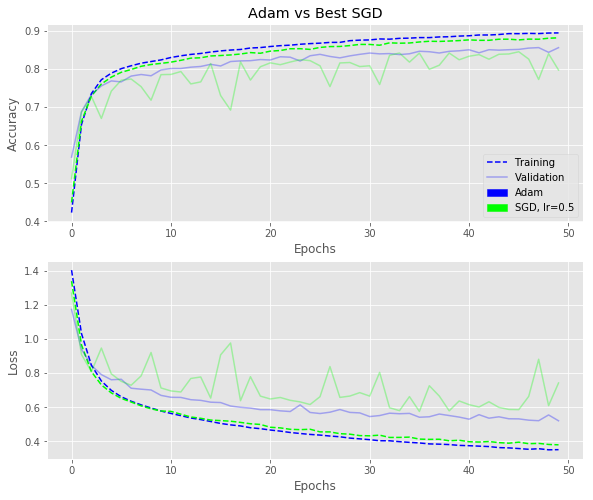

In [19]:
plot_acc_loss(histories, labels, 'Adam vs Best SGD', '', 'val_')

## Exercise 3: Overfitting and early stopping with Adam

### Ex 3: Description

Run the above simulation with Adam for sufficiently many epochs (be patient!) until you see clear overfitting.

1. Plot the learning curves of a fit with Adam and sufficiently many epochs and answer the questions below.

A simple, but effective mean to avoid overfitting is early stopping, i.e. a fit is not run until convergence but stopped as soon as the validation error starts to increase. We will use early stopping in all subsequent exercises.

### Ex 3: Solution

In [ ]:
exthist_longadam = ExtendedHistory()

In [ ]:
shuffle_weights(one_hl)
np.save('output_Olesya/exthist_longadam_weights', one_hl.get_weights())

In [ ]:
%time hist_one_hl_long_adam = one_hl.fit(x_train, y_train, epochs=400, batch_size=128, \
                                         verbose=0, validation_data=(x_test, y_test))
exthist_longadam.add_hist(hist_one_hl_long_adam)

In [ ]:
exthist_longadam.save('output_Olesya/exthist_longadam.txt')

In [20]:
exthist_longadam = ExtendedHistory(fname='output_Olesya/exthist_longadam.txt')

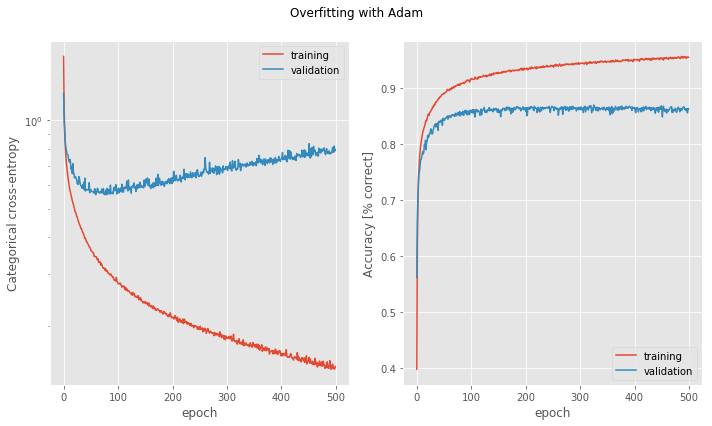

In [21]:
exthist_longadam.plot('Overfitting with Adam')

**Question 1**: At which epoch (approximately) does the model start to overfit? Please answer with one full sentence.

**Answer**: Around epoch 80.

**Question 2**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**:
- At the moment when overfitting starts, the **validation loss** is at its minimum while the **training loss** continues to decrease exponentially (as $exp(-x)$).
- By the time the model starts to overfit, the **validation accuracy** is in the very close neighbourhood of its asymptote behaving as $1 - exp(-x)$ while the **training accuracy** continues to increase logarithmically (=very slowly).

## Exercise 4: Model performance as a function of number of hidden neurons

### Ex 4: Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models with different hidden layer size (between 10 and 1000 hidden neurons) for a fixed number of epochs well beyond the point of overfitting.
2. Collect some statistics by fitting the same models as in 1. for multiple initial conditions. Hints: 1. If you don't reset the random seed, you get different initial conditions each time you create a new model. 2. Let your computer work while you are asleep.
3. Plot summary statistics of the final validation loss and accuracy versus the number of hidden neurons. Hint: [boxplots](https://matplotlib.org/examples/pylab_examples/boxplot_demo.html) (also [here](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.boxplot.html?highlight=boxplot#matplotlib.axes.Axes.boxplot)) are useful. You may also want to use the matplotlib method set_xticklabels.
4. Plot summary statistics of the loss and accuracy for early stopping versus the number of hidden neurons.

### Ex 4: Solution

**Parts 1-2**

In [ ]:
for i in range(3, 11):
    apphist_densities = AppendedHistory(varname='weights')
    for j in range(10):
        start_time = timeit.default_timer()
        one_hl = Sequential()
        one_hl.add(Dense(2**i, input_dim=x_train.shape[1], activation='relu'))
        one_hl.add(Dense(5, input_dim=x_train.shape[1], activation='softmax'))
        np.save('output_Olesya/densities/weights_{}-{}'.format(2**i, j), one_hl.get_weights())
        one_hl.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
        hist_one_hl_density = one_hl.fit(x_train, y_train, epochs=300, batch_size=128, \
                                        verbose=0, validation_data=(x_test, y_test))
        apphist_densities.append_hist(j, hist_one_hl_density)
        elapsed = timeit.default_timer() - start_time
        print('{}: {}'.format(j, elapsed))
    apphist_densities.save('output_Olesya/densities/apphist_densities_{}.txt'.format(2**i))

**Part 3.** Plot summary statistics of the final validation loss and accuracy versus the number of hidden neurons.

**NB**
- For proper comparison, we plot statistics not only for validation, but also for training.
- We take `min(history.history['val_loss'])` to compute best scores (early stopping scores).

In [22]:
fpath = 'output_Olesya/densities/'
box_dict = {
    'acc': [AppendedHistory(fname='{}apphist_densities_{}.txt'.format(fpath, 2**i)).get_ist(-1)['acc'] \
             for i in range(3, 11)],
    'val_acc': [AppendedHistory(fname='{}apphist_densities_{}.txt'.format(fpath, 2**i)).get_ist(-1)['val_acc'] \
             for i in range(3, 11)],
    'loss': [AppendedHistory(fname='{}apphist_densities_{}.txt'.format(fpath, 2**i)).get_ist(-1)['loss'] \
             for i in range(3, 11)],
    'val_loss': [AppendedHistory(fname='{}apphist_densities_{}.txt'.format(fpath, 2**i)).get_ist(-1)['val_loss'] \
             for i in range(3, 11)]
}

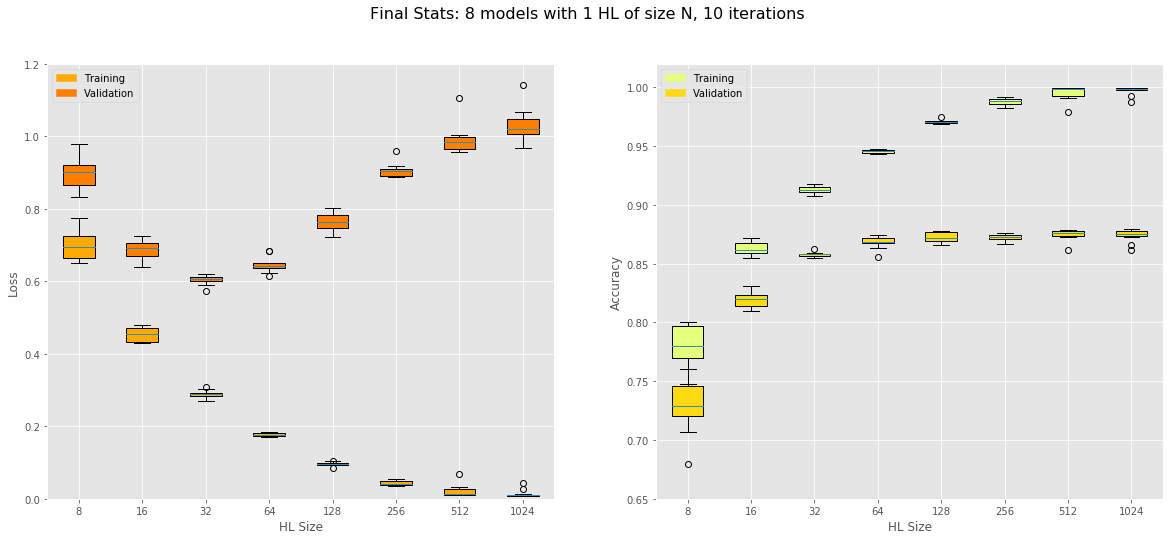

In [23]:
plot_stats(box_dict, 'Final Stats: 8 models with 1 HL of size N, 10 iterations', 'HL Size', \
           [0.0, 1.2], [0.65, 1.02], 'ex4_final_stats_10', labels=2**np.arange(3, 11))

**Part 4.** Plot summary statistics of the loss and accuracy for early stopping versus the number of hidden neurons.

In [24]:
fpath = 'output_Olesya/densities/'
box_dict = {
    'acc': [AppendedHistory(fname='{}apphist_densities_{}.txt'.format(fpath, 2**i)).get_best()['acc'] \
             for i in range(3, 11)],
    'val_acc': [AppendedHistory(fname='{}apphist_densities_{}.txt'.format(fpath, 2**i)).get_best()['val_acc'] \
             for i in range(3, 11)],
    'loss': [AppendedHistory(fname='{}apphist_densities_{}.txt'.format(fpath, 2**i)).get_best()['loss'] \
             for i in range(3, 11)],
    'val_loss': [AppendedHistory(fname='{}apphist_densities_{}.txt'.format(fpath, 2**i)).get_best()['val_loss'] \
             for i in range(3, 11)]
}

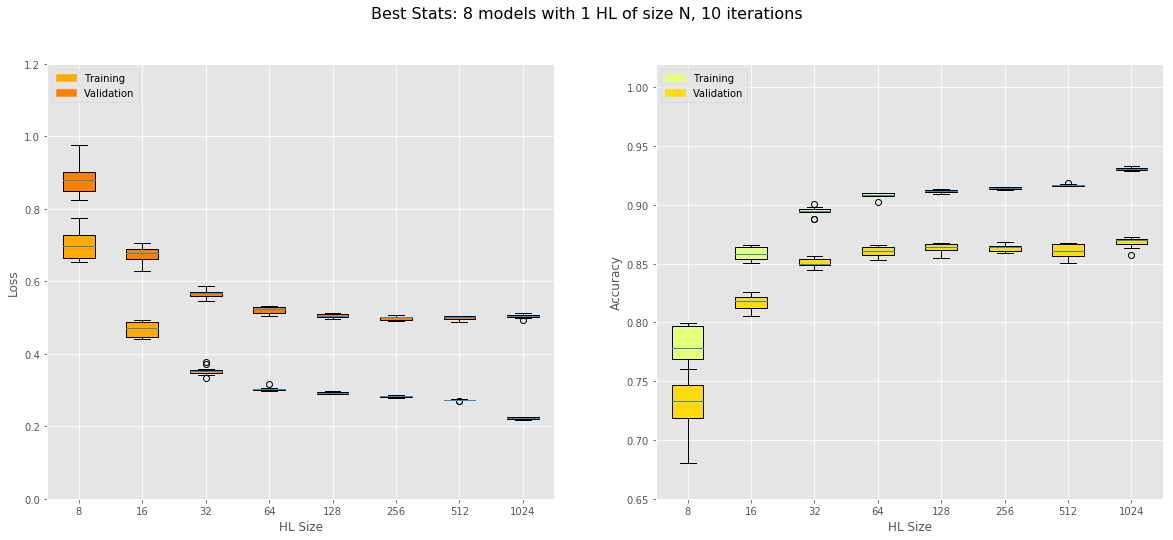

In [25]:
plot_stats(box_dict, 'Best Stats: 8 models with 1 HL of size N, 10 iterations', 'HL Size', \
           [0.0, 1.2], [0.65, 1.02], 'ex4_best_stats_10', labels=2**np.arange(3, 11))

**NB ↓ :** The final results for models with 8, 16 and 32 HL sizes are equal to the best because those models are too simple to overfit (Fig. 4).

In [26]:
dict_ = {
    'acc': [],
    'val_acc': [],
    'loss': [],
    'val_loss': [AppendedHistory(fname='{}apphist_densities_{}.txt'.format(fpath, 2**i)).history['val_loss'][0] \
             for i in range(3, 11)],
    'var': [2**i for i in range(3, 11)]
}

In [27]:
apphist_densities = AppendedHistory(history_=dict_)

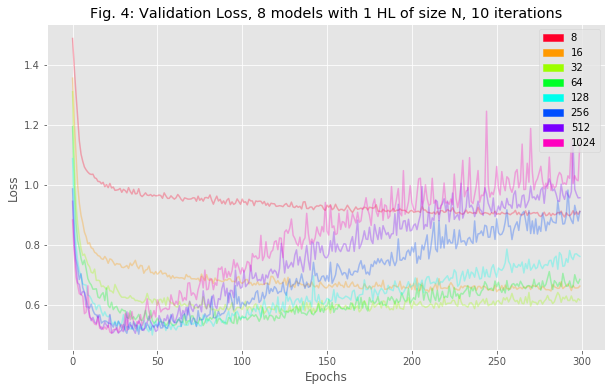

In [28]:
apphist_densities.plot('Fig. 4: Validation Loss, 8 models with 1 HL of size N, 10 iterations', \
                       'val_loss', complementary=False)

## Exercise 5: Comparison to deep models

### Ex 5: Description

Instead of choosing one hidden layer (with many neurons) you experiment here with multiple hidden layers (each with not so many neurons).

1. Fit models with 2, 3 and 4 hidden layers with approximately the same number of parameters as a network with one hidden layer of 100 neurons. Hint: Calculate the number of parameters in a network with input dimensionality N_in, K hidden layers with N_h units, one output layer with N_out dimensions and solve for N_h. Confirm you result with the keras method model.summary().
2. Run each model multiple times with different initial conditions and plot summary statistics of the best validation loss and accuracy versus the number of hidden layers.

### Ex 5: Solution

**Part 1**

A network with one hidden layer of 100 neurons has the following number of parameters:

$$100\cdot(|input|+1) + (100+1)\cdot|output| = 100\cdot(256+1) + (100+1)\cdot5 = 26,205.$$

**1\.** For a system with 2 hidden layers to have a similar number of parameters, we should solve this:

$$x\cdot(|input|+1) + (x+1)\cdot y + (y+1)\cdot|output| = 26,205.$$

We want the number of layers not to influence the network dynamics, so we need that $x \approx y$.

The solution in this case is $x \approx y \approx 77$.

**2\.** For 3 hidden layers, we have

$$x\cdot(|input|+1) + (x+1)\cdot y + (y+1)\cdot z + (z+1)\cdot|output| = 26,205.$$

Here we get $x \approx y \approx z \approx 66$.

**3\.** For 4, we have

$$x\cdot(|input|+1) + (x+1)\cdot y + (y+1)\cdot z + (z+1)\cdot\alpha + (\alpha +1)\cdot|output| = 26,205.$$

We get $x \approx y \approx z \approx \alpha \approx 59$.

The general solution can be found by setting the layersize for each to N_h, using the notation suggested above:
    $$ (N_{in}+1)*N_h +(N_h+1)*N_h*(K-1) + N_{out}*(N_h+1) = 26,205 $$
    
We solve for $N_h$:
   $$N_h = \frac{(N_{in}+N_{out}+K)\pm \sqrt{(N_{in}+N_{out}+K)^2-4(K-1)*(N_{out}-26205)}}{2(K-1)}
   $$
   
 (obviously the only valid solutions are for N_h > 0)


We decided to sightly change the layersizes in order to more closely approximate the number of parameters.

In [29]:
dens_list = [[78, 73], [66, 66, 67], [59, 59, 59, 59]]
one_hl = Sequential()
one_hl.add(Dense(100, input_dim=x_train.shape[1], activation='relu'))
one_hl.add(Dense(5, input_dim=x_train.shape[1], activation='softmax'))
one_hl.summary()

for denss in dens_list:
    equal_n_params = Sequential()
    equal_n_params.add(Dense(denss[0], input_dim=x_train.shape[1], activation='relu'))
    for dens in denss[1:]:
        equal_n_params.add(Dense(dens, activation='relu'))
    equal_n_params.add(Dense(5, input_dim=x_train.shape[1], activation='softmax'))
    equal_n_params.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 100)               25700     
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 505       
Total params: 26,205
Trainable params: 26,205
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 78)                20046     
_________________________________________________________________
dense_6 (Dense)              (None, 73)                5767      
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 370       
Total params: 26,183
Trainable params: 26,183
Non-trainable params: 0
__

In [30]:
def ex5(iters, epochs):
    """Training for Ex 5.
    
    Params:
    iters - positive int, number of iterations for each model;
    epochs - number of epochs for each iteration.
    """
    dens_list = [[78, 73], [66, 66, 67], [59, 59, 59, 59]]

    for denss in dens_list:
        apphist_layers = AppendedHistory(varname='weights')
        for j in range(iters):
            start_time = timeit.default_timer()
            equal_n_params = Sequential()
            equal_n_params.add(Dense(denss[0], input_dim=x_train.shape[1], activation='relu'))
            if len(denss) > 1:
                for dens in denss[1:]:
                    equal_n_params.add(Dense(dens, activation='relu'))
            equal_n_params.add(Dense(5, input_dim=x_train.shape[1], activation='softmax'))
            equal_n_params.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
            hist_equal_n_params = equal_n_params.fit(x_train, y_train, epochs=epochs, batch_size=128, \
                                            verbose=0, validation_data=(x_test, y_test))
            apphist_layers.append_hist(j, hist_equal_n_params)
            elapsed = timeit.default_timer() - start_time
            print('{}: {}'.format(j, elapsed))
        apphist_layers.save('/output/apphist_layers_{}_{}.txt'.format(iters, denss[0]))

**Part 2**

**NB**
- For proper comparison, we plot statistics not only for validation, but also for training.
- We take `min(history.history['val_loss'])` to compute the best scores.

**First**, we compute with `iters = 10`, and `epochs = 300`. Might be not enough statistically but will help account for overfitting.

In [ ]:
# Cloud computed on FloydHub.
ex5(10, 300)

Here ↓ are the distributions we get in this case.

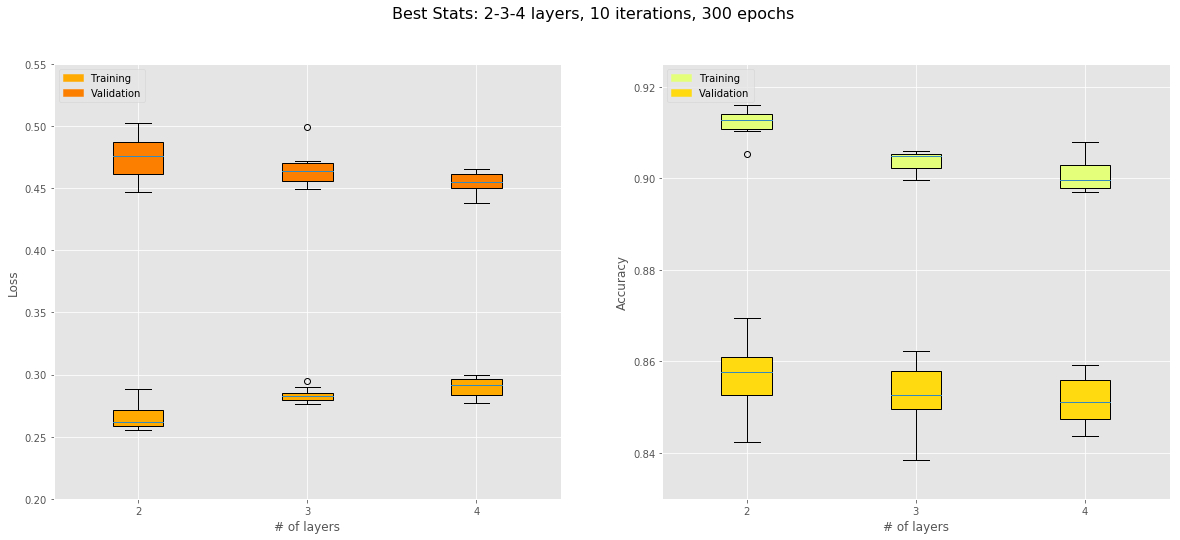

In [31]:
plot_stats(get_box_dict('layers', 10), 'Best Stats: 2-3-4 layers, 10 iterations, 300 epochs', '# of layers', \
           [0.2, 0.55], [0.83, 0.925], 'ex5_best_stats_10', labels=[2, 3, 4])

**Second**, we decide to find the minimal overfitting point in order to compute more in less time.

In [32]:
fpath = 'output_Olesya/layers/'
dict_ = {
    'acc': [],
    'val_acc': [],
    'loss': [],
    'val_loss': [AppendedHistory(fname='{}apphist_layers_10_{}.txt'.format(fpath, i)).history['val_loss'][0] \
             for i in range(2, 5)],
    'var': [2, 3, 4]
}

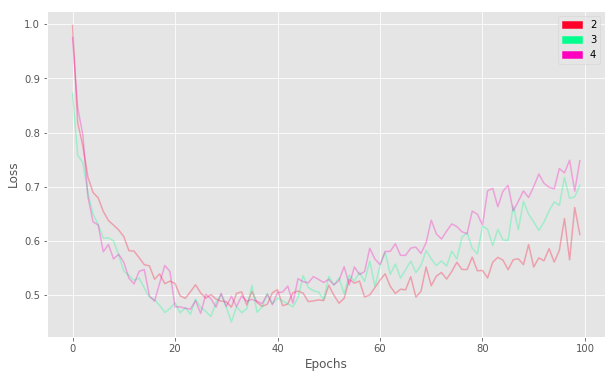

In [33]:
AppendedHistory(history_=dict_).plot('', 'val_loss', complementary=False)

Looks like **50 epochs** is more than enough in terms of overfitting. Let's check.

In [34]:
# Check whether the best val_loss over 300 epochs lies within (0, epochs_...) interval.
epochs_chosen = 50
epochs_min = 44

list_1 = [np.mean(AppendedHistory(fname='{}apphist_layers_10_{}.txt'.format(fpath, i)).get_best()['val_loss']) \
             for i in range(2, 5)]
list_2 = [np.mean(AppendedHistory(fname='{}apphist_layers_10_{}.txt'.format(fpath, i)).get_sample_slice(slice(0, 44)).get_best()['val_loss']) \
             for i in range(2, 5)]
list_1 == list_2

True

**Next**, we compute with `epochs = 50` and `iters = 33` (to account for **statistical significance**).

In [ ]:
# Cloud computed on FloydHub.
ex5(33, 50)

Here ↓ are the stats we get in this case.

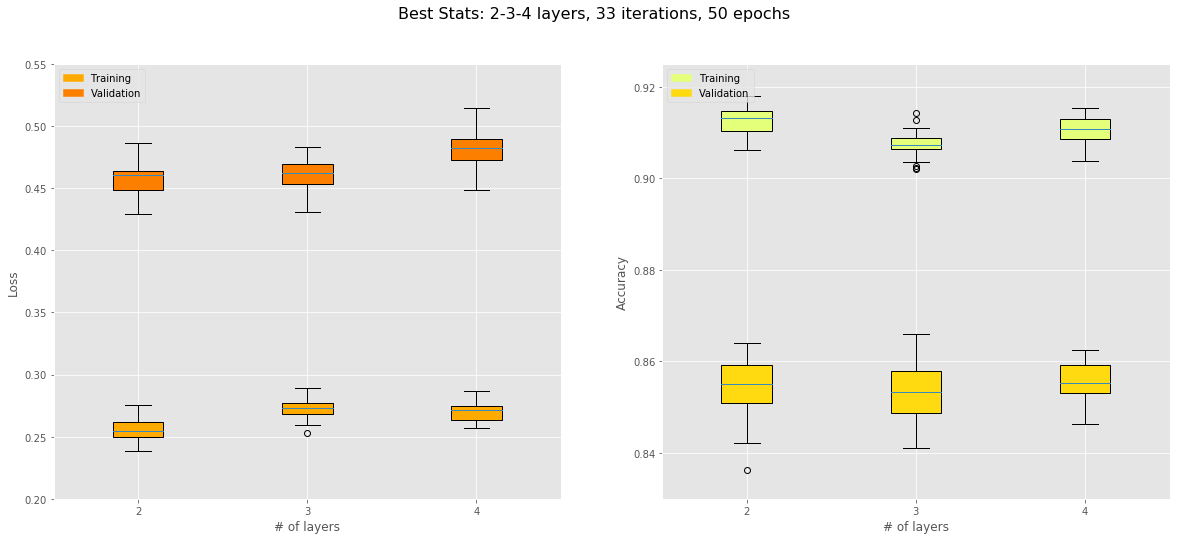

In [35]:
plot_stats(get_box_dict('layers', 33), 'Best Stats: 2-3-4 layers, 33 iterations, 50 epochs', '# of layers', \
           [0.2, 0.55], [0.83, 0.925], 'ex5_best_stats_33', labels=[2, 3, 4])

Now, we don't violate anything if we **merge the two computations** to get better stats (because the best for the first run lie in (0, 50) epoch interval that we used for the second run).

In [36]:
# Merge the two history files.
apphists = []
for i in range(2, 5):
    apphist = AppendedHistory(fname='{}apphist_layers_33_{}.txt'.format(fpath, i))
    apphist.merge(AppendedHistory(fname='{}apphist_layers_10_{}.txt'.format(fpath, i)))
    apphists.append(apphist)
for i in range(0, 3):
    apphists[i].save('output_Olesya/layers/apphist_layers_43_{}.txt'.format(i+2))

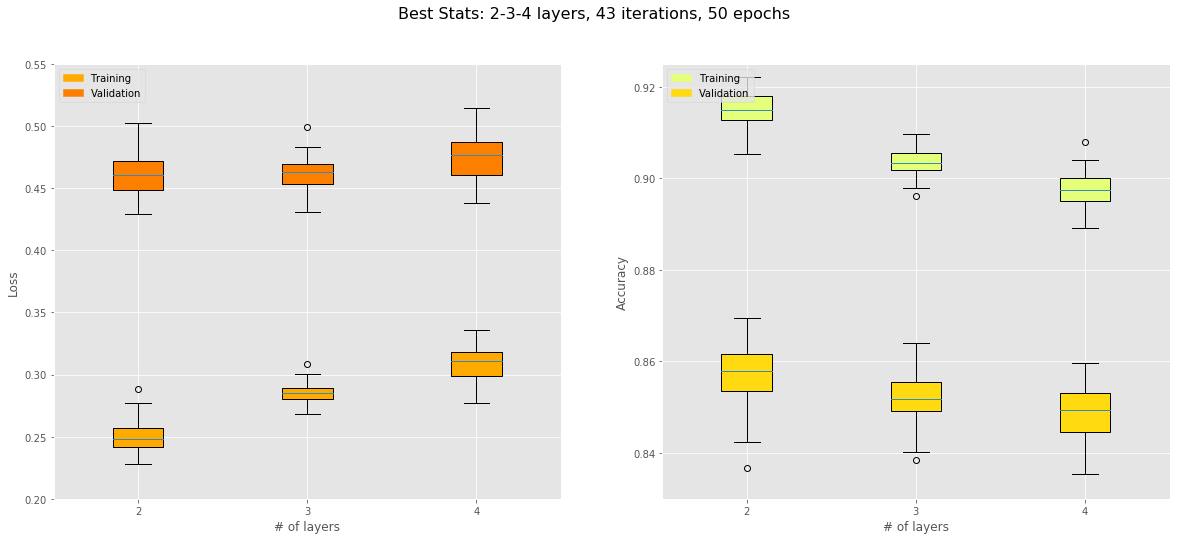

In [37]:
plot_stats(get_box_dict('layers', 43), 'Best Stats: 2-3-4 layers, 43 iterations, 50 epochs', '# of layers', \
           [0.2, 0.55], [0.83, 0.925], 'ex5_best_stats_43', labels=[2, 3, 4])

The **conclusion** here would be that, for this task, 2 HL models perform slightly better than 3-4 HL models with the similar number of parameters (in terms of `val_acc` got for the minimal `val_loss`).

**Best Model**

We find the best model by finding the best `val_acc` score for 'early stopped' models.

In [38]:
best_acc = np.array(get_box_dict('layers', 43)['val_acc'])
np.unravel_index(np.argmax(best_acc), best_acc.shape)

(0, 40)

A 2 HL model is the best.

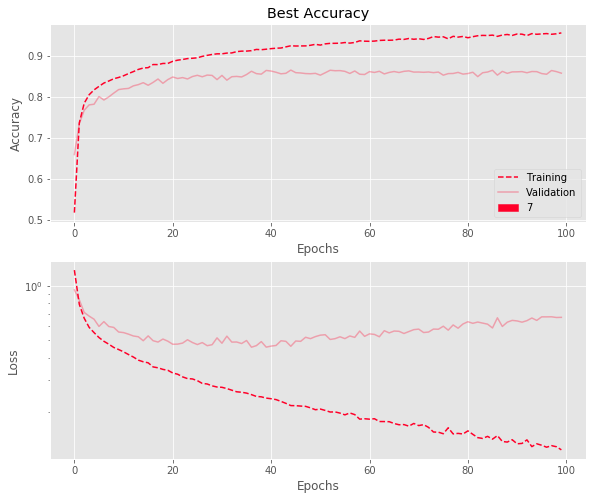

In [39]:
AppendedHistory(fname='output_Olesya/layers/apphist_layers_43_4.txt' \
               ).get_slice(40).plot_acc_loss('Best Accuracy', '', 'val_')

## Exercise 6: Tricks (regularization, batch normalization, dropout)

### Ex 6: Description

Overfitting can also be counteracted with regularization and dropout. Batch normalization is supposed to mainly decrease convergence time.

1. Try to improve the best validation scores of the model with 1 layer and 100 hidden neurons and the model with 4 hidden layers. Experiment with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases.
2. After you have found good settings, plot for both models the learning curves of the naive model you fitted in the previous exercises together with the learning curves of the current version.
3. For proper comparison, plot also the learning curves of the two current models in a third figure.

### Ex 6: Solution

By trying L1 and L2 regularisations, we find that **L1** regularisation does not work well on this data. **L2** works well, however, **dropout** layers give the best performance.

In [16]:
# model with 1 hidden layer
# add dropout to each layer, use some batch normalisation for speed-up
#model with 1 layer and 100 hidden neurons
activation = 'relu'
loss = 'categorical_crossentropy'
metrics=['accuracy']
minibatch = 128 #5. define minibatch size
num_classes = y_test.shape[1]
optimizer = Adam()

epochs = 150

model = Sequential()
model.add(Dense(100, activation=activation, input_dim=x_train.shape[1]))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax', name='outputlayer'))

model.compile(loss=loss, 
              optimizer=optimizer,
              metrics=metrics)

model.summary()
history = model.fit(x_train, y_train, 
                      batch_size=minibatch, 
                      epochs=epochs, 
                      validation_data=(x_test, y_test), 
                      verbose=0)


score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 100)               25700     
_________________________________________________________________
batch_normalization_4 (Batch (None, 100)               400       
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
outputlayer (Dense)          (None, 5)                 505       
Total params: 26,605
Trainable params: 26,405
Non-trainable params: 200
_________________________________________________________________
Test loss: 0.486684692392
Test accuracy: 0.869216033009


In [68]:
apphist_100Neurons = AppendedHistory(history_=[history.history])
apphist_4layers.history['var'] = ['100 neurons model']
apphist_100Neurons.save('output_Leonore/ex6_1layer_100neurons.txt')

In [18]:
# model with 4 hidden layers
# add dropout to each layer, use some batch normalisation for speed-up
model_4 = Sequential()
model_4.add(Dense(59, activation=activation, input_dim=x_train.shape[1]))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.125))
model_4.add(Dense(59, activation=activation, input_dim=59))
model_4.add(Dropout(0.125))
model_4.add(Dense(59, activation=activation, input_dim=59))
model_4.add(Dropout(0.125))
model_4.add(Dense(59, activation=activation, input_dim=59))
model_4.add(Dropout(0.25))
model_4.add(BatchNormalization())
model_4.add(Dense(num_classes, activation='softmax', name='outputlayer'))

model_4.compile(loss=loss, 
              optimizer=optimizer,
              metrics=metrics)
model_4.summary()
history_4 = model_4.fit(x_train, y_train, 
                      batch_size=minibatch, 
                      epochs=epochs, 
                      validation_data=(x_test, y_test), 
                      verbose=0)

#get score
score = model_4.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 59)                15163     
_________________________________________________________________
batch_normalization_5 (Batch (None, 59)                236       
_________________________________________________________________
dropout_7 (Dropout)          (None, 59)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 59)                3540      
_________________________________________________________________
dropout_8 (Dropout)          (None, 59)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 59)                3540      
_________________________________________________________________
dropout_9 (Dropout)          (None, 59)                0         
__________

In [66]:
apphist_4layers = AppendedHistory(history_=[history_4.history])
apphist_4layers.history['var'] = ['4 layer model']
apphist_4layers.save('output_Leonore/ex6_4layer.txt')

In [70]:
apphist_compare = AppendedHistory(fname='output_Olesya/layers/apphist_layers_43_4.txt'\
                              ).get_slice(40)
apphist_compare.history['var'] = ['Naive model']
apphist_compare.merge(AppendedHistory(fname='output_Leonore/ex6_4layer.txt'))
apphist_compare.merge(AppendedHistory(fname='output_Leonore/ex6_1layer_100neurons.txt'))

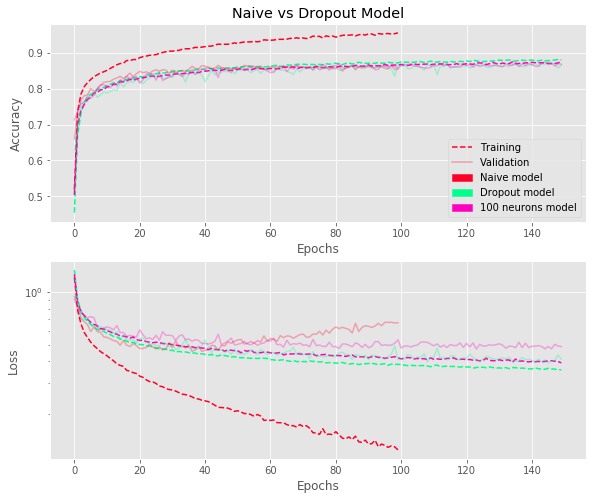

In [71]:
# 2. plot learning curves vs so far best performing model
apphist_compare.plot_acc_loss('Naive vs Dropout Model', '', 'val_')

In [72]:
# 3. learning curves of two current models in a third figures
apphist_compare_current = AppendedHistory(fname='output_Leonore/ex6_1layer_100neurons.txt')
apphist_compare_current.merge(AppendedHistory(fname='output_Leonore/ex6_4layer.txt'))

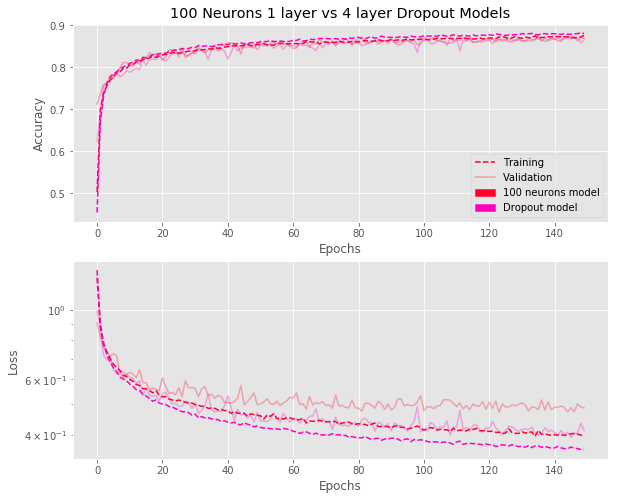

In [73]:
apphist_compare_current.plot_acc_loss('100 Neurons 1 layer vs 4 layer Dropout Models', '', 'val_')

## Exercise 7: Convolutional networks

### Ex 7: Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with the parameters and fit it. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_cnn](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py).
2. Plot the learning curves of the convolutional neural network together with the so far best performing model.

### Ex 7: Solution

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 64)          36928     
_________________________________________________________________
batch_normalization_7 (Batch (None, 6, 6, 64)          256       
__________

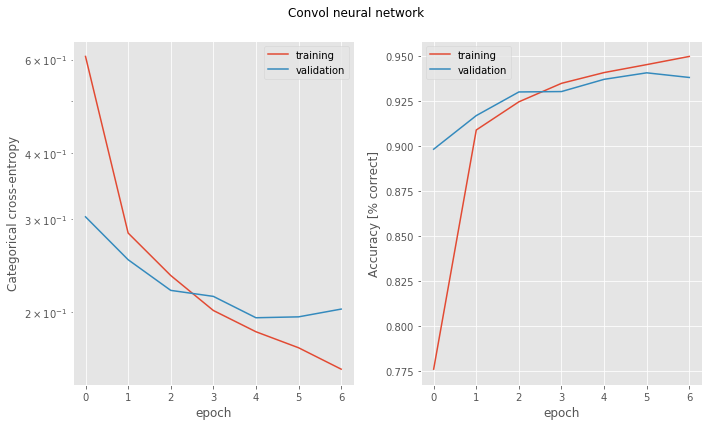

In [20]:
# 1. Neural network design.
batch_size = 128
num_classes = 5
epochs = 7 #change to 12 for cㅁ 95% validation acc

img_rows, img_cols = 16, 16

# change input shape
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

model = Sequential()

# four convolutional layers + regularisation methods
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape, padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.125))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu'))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.125))
model.add(Flatten())

# neural network on top
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss="categorical_crossentropy",
              optimizer=Adam(),
              metrics=['accuracy'])


model.summary()

# fit model
history_cnn = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))


# plot history
plot_history(history_cnn, 'Convolutional neural network')
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) #ca 0.95 after 12 epochs

In [21]:
apphist_cnn = AppendedHistory(history_=[history_cnn.history])
apphist_4layers.history['var'] = ['CNN model']
apphist_cnn.save('output_Leonore/ex6_cnn.txt')

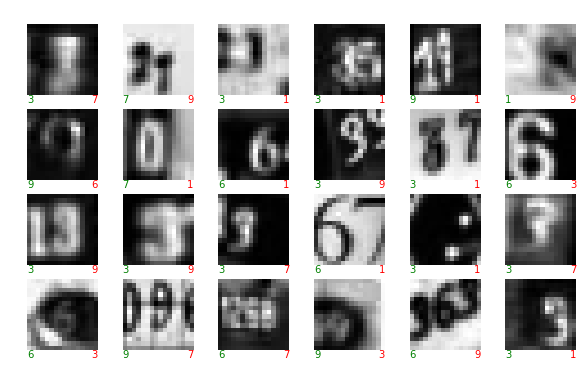

In [22]:
# show missclassified, we see missclassified are bad samples
pred = model.predict(x_test)
indexes = np.nonzero(pred.argmax(axis=1) != y_test.argmax(axis=1))[0]
plot_some_samples(x_test, y_test, pred, indexes, label_mapping = subset_of_classes)

In [30]:
# 2. plot learning curves vs so far best preforming model
apphist_compare_drop_cnn = AppendedHistory(fname='output_Leonore/ex6_4layer.txt')
apphist_compare_drop_cnn.merge(AppendedHistory(fname='output_Leonore/ex6_cnn.txt'))

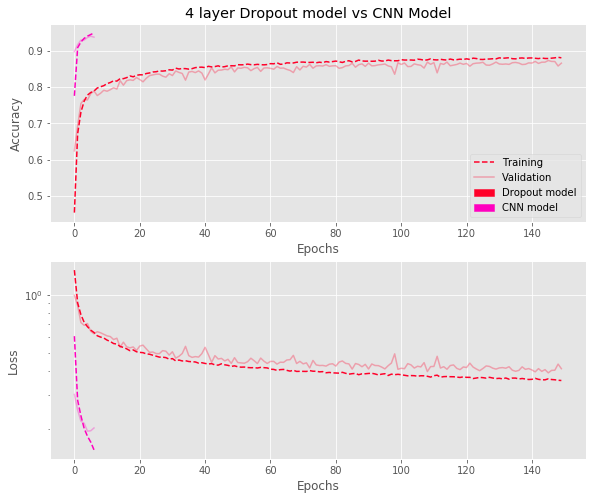

In [31]:
apphist_compare_drop_cnn.plot_acc_loss('4 layer Dropout model vs CNN Model', '', 'val_')